In [1]:
import jax
import chex
import jax.numpy as jnp
import jax.random as random
import flax.linen as nn
from typing import Sequence
from scipy.integrate import solve_ivp

import numpy as np
import matplotlib.pyplot as plt

import optax
from flax.training.train_state import TrainState

from stoch_ham.simple_pendulum.data import get_dataset, hamiltonian
from stoch_ham.utils import l2_loss

In [2]:
class MLP(nn.Module):
    """
    Simple multi-layer perceptron model in Flax.
    From https://github.com/google/flax.
    """
    features: Sequence[int]

    @nn.compact
    def __call__(self, x):
        for feat in self.features[:-1]:
            x = nn.tanh(nn.Dense(feat)(x))
        x = nn.Dense(self.features[-1])(x)
        return x


def hnn_predict_energies(train_state, dataset):
    """
    Predict the HNN output.
    :param train_state: The train state.
    :param dataset: The batched dataset.
    :return: An array of energies corresponding to the dataset.
    """
    num_batches = len(dataset)
    energy_list = []
    for i in range(num_batches):
        inputs, _ = dataset[i]
        H = train_state.apply_fn({'params': train_state.params}, inputs).squeeze()
        energy_list.append(H)

    return jnp.concatenate(energy_list)


def hnn_predict_derivatives(train_state, params, x):
    """
    Derivative predictions by HNN.
    :param train_state: The train train_state.
    :param params: Neural network parameters.
    :param x: Input data.
    :return: Predictions (q_dot, p_dot).
    """
    H = lambda inputs: jnp.sum(train_state.apply_fn({'params': params}, inputs))
    derivatives = jax.grad(H)(x)
    chex.assert_equal_shape([derivatives, x])

    # Cases for batch and single inputs.
    if derivatives.ndim == 2:
        preds = jnp.column_stack((derivatives[:, 1], -derivatives[:, 0]))
    else:
        preds = jnp.array([derivatives[1], -derivatives[0]])

    return preds


def rk4_step(fun, x, dt):
    """
    Single step of the RK4 integrator.
    :param fun: The derivative function to integrate.
    :param x: The current state.
    :param dt: The time step.
    :return: State x(t + dt).
    """
    k1 = fun(x)
    k2 = fun(x + dt * k1 / 2)
    k3 = fun(x + dt * k2 / 2)
    k4 = fun(x + dt * k3)
    chex.assert_equal_shape([k1, k2, k3, k4, x])
    return x + dt * (k1 + 2 * k2 + 2 * k3 + k4) / 6


def hnn_flow(train_state, params, x, dt):
    """
    Given the current state `x(t)`, compute the next state `x(t + dt)` using HNN.
    :param train_state: The train state.
    :param params: The network parameters.
    :param x: Input data of shape (batch_size, input_dims).
    :param dt: Time step.
    :return: x(t + dt).
    """
    der_fun = lambda xi: hnn_predict_derivatives(train_state, params, xi)
    return rk4_step(der_fun, x, dt)


def hnn_loss(train_state, params, data, dt):
    """
    Loss function for HNN.
    :param train_state: The train train_state.
    :param params: Network parameters.
    :param data: Tuple (inputs, targets).
    :return: Average L2 loss over batches.
    """
    inputs, targets = data
    predictions = hnn_flow(train_state, params, inputs, dt)
    return l2_loss(predictions, targets)

## Get the data ready

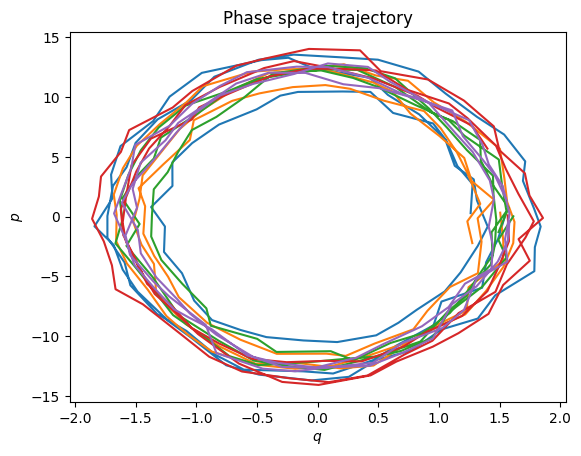

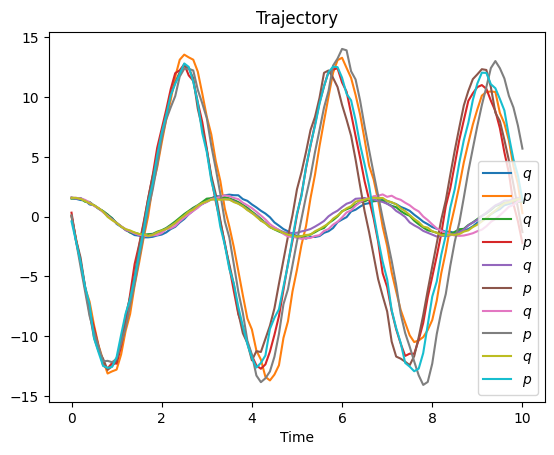

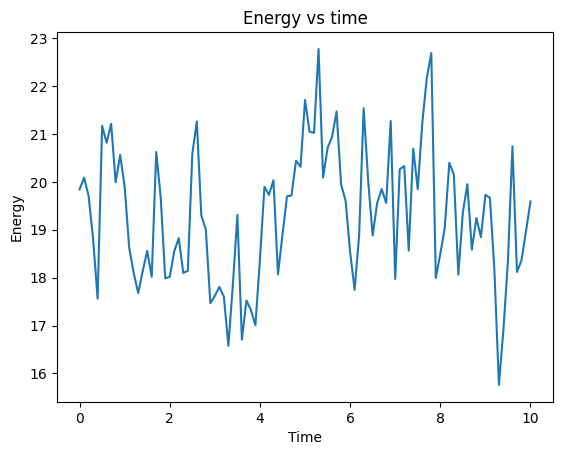

In [12]:
seed = 12
key = random.PRNGKey(seed)

params = {
    'mass': 1.,
    'length': 2.,
    'lambda': 5.,
    'q': 0.01
}

x0 = jnp.array([jnp.pi / 2, 0.])
t_span = (0., 10.)

trajs = get_dataset(key, 5, params, x0, t_span)

ts = jnp.linspace(*t_span, len(trajs[0]))

plt.figure()
for traj in trajs:
    plt.plot(traj[:, 0], traj[:, 1])
plt.xlabel(r"$q$")
plt.ylabel(r"$p$")
plt.title("Phase space trajectory")
plt.show()

plt.figure()
for traj in trajs:
    plt.plot(ts, traj[:, 0], label=r"$q$")
    plt.plot(ts, traj[:, 1], label=r"$p$")
plt.title("Trajectory")
plt.xlabel("Time")
plt.legend()
plt.show()

energies = jax.vmap(hamiltonian, in_axes=(0, None))(trajs[4], params)
plt.figure()
plt.plot(ts, energies)
plt.title("Energy vs time")
plt.xlabel("Time")
plt.ylabel("Energy")
plt.show()

In [4]:
X, Y = [], []
for traj in trajs:
    x = traj[:-1]
    y = traj[1:]
    X.append(x)
    Y.append(y)

X, Y = jnp.concatenate(X, axis=0), jnp.concatenate(Y)
X.shape

(500, 2)

In [5]:
# 0. Initialize the hyperparameters.
num_epochs = 10000
batch_size = 250
features = [256, 1]
learning_rate = 1e-3
key = random.PRNGKey(100)
rng = np.random.default_rng(12345)
dt = 0.1

train_data = (X[:250], Y[:250])
val_data = (X[250:], Y[250:])

# 2. Define and initialize the model.
input_shape = (2,)  # (x, y) is the input to the encoder.
model = MLP(features)

init_data = jnp.ones((batch_size, *input_shape))

loss_fn = hnn_loss


@jax.jit
def train_step(state, batch):
    """
    Train step for a single batch.
    :param state: The train state.
    :param batch: Batched data (inputs, targets).
    :return: The updated train state and loss.
    """
    grad_fn = jax.value_and_grad(loss_fn, argnums=1)
    loss, grads = grad_fn(state, state.params, batch, dt)
    state = state.apply_gradients(grads=grads)
    return state, loss


@jax.jit
def compute_loss(state, dataset):
    """
    Compute the loss over a dataset.
    :param state: The train state.
    :param dataset: Batched dataset.
    :return: The loss over a dataset.
    """
    loss = loss_fn(state, state.params, dataset, dt)
    return loss


# Create the train state
key, subkey = random.split(key)
state = TrainState.create(
    apply_fn=model.apply,
    params=model.init(subkey, init_data)['params'],
    tx=optax.adam(learning_rate),
)

# 5. Train the model.
for epoch in range(num_epochs):
    # Print the validation loss before the model is trained.
    if epoch == 0:
        val_loss = compute_loss(state, val_data)
        print(val_loss)
        print(f"Untrained validation loss = {val_loss:.3E}")

    # Loop over batches.
    state, epoch_loss = train_step(state, train_data)

    # Print the training and validation loss every 50 epochs.
    if (epoch + 1) % 50 == 0:
        val_loss = compute_loss(state, val_data)
        print(f"Epoch {epoch + 1:04d} - Train loss = {epoch_loss:.3E} - Val loss = {val_loss:.3E}")

2.7210617
Untrained validation loss = 2.721E+00
Epoch 0050 - Train loss = 2.698E+00 - Val loss = 2.717E+00
Epoch 0100 - Train loss = 2.596E+00 - Val loss = 2.624E+00
Epoch 0150 - Train loss = 2.265E+00 - Val loss = 2.300E+00
Epoch 0200 - Train loss = 1.617E+00 - Val loss = 1.642E+00
Epoch 0250 - Train loss = 9.671E-01 - Val loss = 9.911E-01
Epoch 0300 - Train loss = 5.246E-01 - Val loss = 5.537E-01
Epoch 0350 - Train loss = 3.010E-01 - Val loss = 3.357E-01
Epoch 0400 - Train loss = 2.156E-01 - Val loss = 2.552E-01
Epoch 0450 - Train loss = 1.839E-01 - Val loss = 2.229E-01
Epoch 0500 - Train loss = 1.712E-01 - Val loss = 2.087E-01
Epoch 0550 - Train loss = 1.649E-01 - Val loss = 2.010E-01
Epoch 0600 - Train loss = 1.609E-01 - Val loss = 1.961E-01
Epoch 0650 - Train loss = 1.578E-01 - Val loss = 1.925E-01
Epoch 0700 - Train loss = 1.552E-01 - Val loss = 1.899E-01
Epoch 0750 - Train loss = 1.529E-01 - Val loss = 1.878E-01
Epoch 0800 - Train loss = 1.506E-01 - Val loss = 1.857E-01
Epoch 08

Epoch 7000 - Train loss = 6.372E-02 - Val loss = 2.831E-01
Epoch 7050 - Train loss = 6.343E-02 - Val loss = 2.822E-01
Epoch 7100 - Train loss = 6.317E-02 - Val loss = 2.812E-01
Epoch 7150 - Train loss = 6.291E-02 - Val loss = 2.803E-01
Epoch 7200 - Train loss = 6.266E-02 - Val loss = 2.810E-01
Epoch 7250 - Train loss = 6.241E-02 - Val loss = 2.853E-01
Epoch 7300 - Train loss = 6.218E-02 - Val loss = 2.931E-01
Epoch 7350 - Train loss = 6.195E-02 - Val loss = 2.927E-01
Epoch 7400 - Train loss = 6.173E-02 - Val loss = 2.919E-01
Epoch 7450 - Train loss = 6.151E-02 - Val loss = 3.027E-01
Epoch 7500 - Train loss = 6.216E-02 - Val loss = 3.011E-01
Epoch 7550 - Train loss = 6.115E-02 - Val loss = 3.056E-01
Epoch 7600 - Train loss = 6.095E-02 - Val loss = 3.064E-01
Epoch 7650 - Train loss = 6.078E-02 - Val loss = 3.086E-01
Epoch 7700 - Train loss = 6.060E-02 - Val loss = 3.148E-01
Epoch 7750 - Train loss = 6.043E-02 - Val loss = 3.194E-01
Epoch 7800 - Train loss = 6.025E-02 - Val loss = 3.177E-

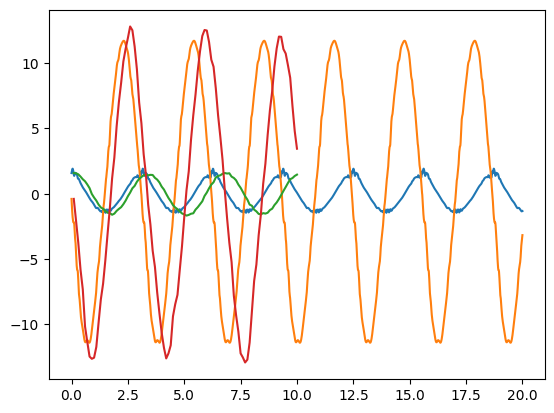

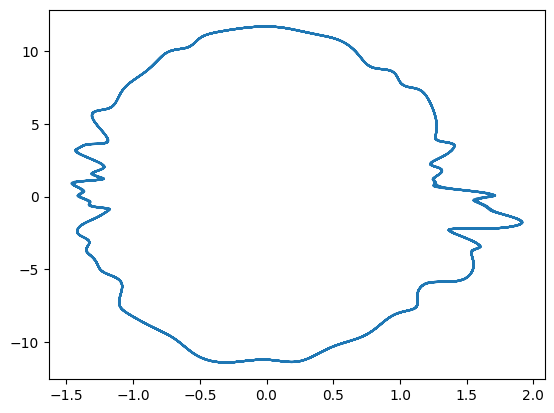

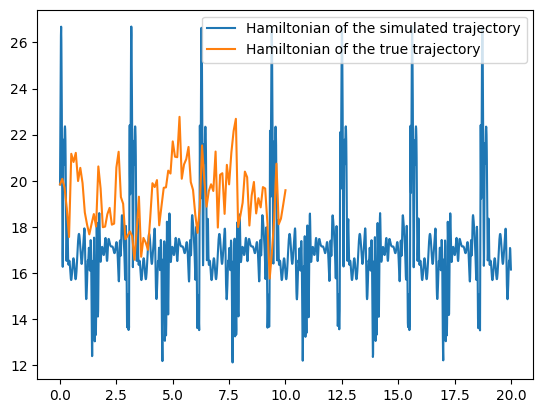

In [22]:
@jax.jit
def hnn_predict_single(train_state, params, x):
    """
    Predictions for HNN.
    :param train_state: The train state.
    :param params: Neural network parameters.
    :param x: Input data.
    :return: Predictions (q_dot, p_dot).
    """
    input_dims = len(x)
    H = lambda inputs: train_state.apply_fn({'params': params}, inputs).squeeze()
    derivatives = jax.jacrev(H)(x)
    chex.assert_shape(derivatives, (input_dims,))

    dHdq, dHdp = derivatives
    preds = jnp.array([dHdp, -dHdq])
    chex.assert_equal_shape([preds, x])
    return preds


def predict_trajectory(train_state, initial_state, t_span, dt):
    t = t_span[0]
    x = initial_state
    trajectory = [x]

    while t <= t_span[1]:
        dxdt = hnn_predict_single(train_state, train_state.params, x)
        x += dxdt * dt
        t += dt
        trajectory.append(x)

    return jnp.array(trajectory)


def simulate_trajectory(dynamics_fn, initial_state, t_span, ts):
    solver = solve_ivp(
        fun=dynamics_fn,
        t_span=t_span,
        y0=initial_state,
        t_eval=ts,
        rtol=1e-10
    )
    trajectory = solver.y.T
    return trajectory


test_data = X[400:]
initial_state = test_data[0]

dyn_fun = lambda t, x: hnn_predict_derivatives(state, state.params, x)
jit_dyn_fun = jax.jit(dyn_fun)
t_eval = np.linspace(0, 20, 2000)
sim_traj = simulate_trajectory(jit_dyn_fun, initial_state, (0, 20), t_eval)
sim_energies = jax.vmap(hamiltonian, (0, None))(sim_traj, params)
plt.figure()
plt.plot(t_eval, sim_traj[:, 0], label=r'q')
plt.plot(t_eval, sim_traj[:, 1], label=r'p')
plt.plot(ts[1:], test_data[:, 0])
plt.plot(ts[1:], test_data[:, 1])
plt.show()

plt.figure()
plt.plot(sim_traj[:, 0], sim_traj[:, 1])
plt.show()

plt.figure()
plt.title("Trajectory Hamiltonians")
plt.plot(t_eval, sim_energies, label="Simulated trajectory")
plt.plot(ts, energies, label="True trajectory")
plt.legend()
plt.show()